In [1]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import log_loss
import shap
from imblearn.over_sampling import SMOTE


import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

## 1. Load the Data

In [ ]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [3]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [4]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp = df_tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp = df_tmp.assign(
            home_division=df_tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=df_tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        df_tmp = df_tmp[id_cols + home_cols + away_cols]
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_games.head()

Reading ../data/games/2010.parquet from cached data
Reading ../data/games/2011.parquet from cached data
Reading ../data/games/2012.parquet from cached data
Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo
0,302450154,2010,1,regular,True,False,3630.0,154,Wake Forest,ACC,fbs,53.0,NaN,2506,Presbyterian,Big South,fcs,13.0,NaN
1,302452050,2010,1,regular,True,False,3919.0,2050,Ball State,Mid-American,fbs,27.0,NaN,2546,Southeast Missouri State,OVC,fcs,10.0,NaN
2,302452428,2010,1,regular,True,False,3862.0,2428,North Carolina Central,MEAC,fcs,59.0,NaN,2304,Johnson C Smith,None,None,0.0,NaN
3,302452117,2010,1,regular,True,False,3786.0,2117,Central Michigan,Mid-American,fbs,33.0,NaN,2261,Hampton,MEAC,fcs,0.0,NaN
4,302452710,2010,1,regular,True,False,3746.0,2710,Western Illinois,MVFC,fcs,45.0,NaN,2674,Valparaiso,Pioneer,fcs,0.0,NaN


In [5]:
# Load weather data
all_dfs = []

weather_dir = join(DATA_DIR, 'weather')
if not os.path.exists(weather_dir):
    os.makedirs(weather_dir)

for year in YEARS:
    file_path = join(weather_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} weather data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_weather(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_weather = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_weather.head()

Reading ../data/weather/2010.parquet from cached data
Reading ../data/weather/2011.parquet from cached data
Reading ../data/weather/2012.parquet from cached data
Reading ../data/weather/2013.parquet from cached data
Reading ../data/weather/2014.parquet from cached data
Reading ../data/weather/2015.parquet from cached data
Reading ../data/weather/2016.parquet from cached data
Reading ../data/weather/2017.parquet from cached data
Reading ../data/weather/2018.parquet from cached data
Reading ../data/weather/2019.parquet from cached data
Reading ../data/weather/2020.parquet from cached data
Reading ../data/weather/2021.parquet from cached data
Reading ../data/weather/2022.parquet from cached data
Reading ../data/weather/2023.parquet from cached data
Reading ../data/weather/2024.parquet from cached data


,id,season,week,season_type,start_time,game_indoors,home_team,home_conference,away_team,away_conference,venue_id,venue,temperature,dew_point,humidity,precipitation,snowfall,wind_direction,wind_speed,pressure,weather_condition_code,weather_condition
0,303240245,2010,12,regular,2010-11-21 01:00:00+00:00,False,Texas A&M,Big 12,Nebraska,Big 12,3795,Kyle Field,69.8,59.9,71.0,0.0,0,150.0,9.2,1017.4,0.0,None
1,303242294,2010,12,regular,2010-11-20 20:30:00+00:00,False,Iowa,Big Ten,Ohio State,Big Ten,3793,Kinnick Stadium,41.9,29.8,62.0,0.0,0,90.0,12.7,1021.9,0.0,None
2,303242305,2010,12,regular,2010-11-20 17:00:00+00:00,False,Kansas,Big 12,Oklahoma State,Big 12,3833,Memorial Stadium,51.8,40.8,66.0,0.0,0,130.0,12.7,1016.6,0.0,None
3,303240127,2010,12,regular,2010-11-20 17:00:00+00:00,False,Michigan State,Big Ten,Purdue,Big Ten,3936,Spartan Stadium,39.0,27.9,64.0,0.0,0,340.0,7.0,1025.9,0.0,None
4,303240239,2010,12,regular,2010-11-21 01:00:00+00:00,False,Baylor,Big 12,Oklahoma,Big 12,3724,Floyd Casey Stadium,68.0,57.0,68.0,0.0,0,160.0,7.0,1015.8,0.0,None


In [6]:
# Load venue data
venue_dir = join(DATA_DIR, 'venues')
if not os.path.exists(venue_dir):
    os.makedirs(venue_dir)

file_path = join(venue_dir, f'venues.parquet')
if os.path.exists(file_path):
    print(f'Reading {file_path} from cached data')
    df_venues = pd.read_parquet(file_path)
else:
    print(f'Fetching {year} venue data from CFBD API')
    with cfbd.ApiClient(configuration) as api_client:
        api_instance = cfbd.VenuesApi(api_client)
        data = api_instance.get_venues()
    df_venues = pd.DataFrame([val.to_dict() for val in data])
    df_venues.columns = convert_to_snake_case(df_venues.columns)
    df_venues.to_parquet(file_path)

df_venues.head()

Reading ../data/venues/venues.parquet from cached data


,id,name,city,state,zip,country_code,latitude,longitude,capacity,dome,timezone,elevation,construction_year,grass
0,5938,Al Whitehead Field at Greyhound Stadium,Portales,NM,88130,US,34.186192,-103.334397,4000.0,False,None,None,NaN,None
1,218,FIU Stadium,Miami,FL,33199,US,25.752501,-80.377891,20000.0,False,America/New_York,1.718581796,1995.0,False
2,4779,Thomas A. Robinson National Stadium,Nassau,,None,BS,25.055569,-77.358736,15000.0,False,None,3.182889223,1981.0,True
3,5220,Garrison Stadium,Murfreesboro,TN,None,US,36.434053,-77.098431,5000.0,False,None,18.69116974,2007.0,None
4,6043,Bethpage Federal Credit Union Stadium,Brookville,NY,11545,US,40.816284,-73.589546,6000.0,False,America/New_York,236,1966.0,False


In [7]:
# Load drives data
all_dfs = []

drives_dir = join(DATA_DIR, "drives")
if not os.path.exists(drives_dir):
    os.makedirs(drives_dir)

for year in YEARS:
    season_file_path = join(drives_dir, f"{year}.parquet")
    
    if os.path.exists(season_file_path):
        print(f"Reading {season_file_path} from cached data")
        df_season_drives = pd.read_parquet(season_file_path)
    else:
        print(f"Fetching {year} drives data from CFBD API")
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.DrivesApi(api_client)
            data = api_instance.get_drives(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)

        df_tmp["start_time_minutes"] = df_tmp["start_time"].apply(lambda x: x["minutes"])
        df_tmp["start_time_seconds"] = df_tmp["start_time"].apply(lambda x: x["seconds"])
        df_tmp["end_time_minutes"] = df_tmp["end_time"].apply(lambda x: x["minutes"])
        df_tmp["end_time_seconds"] = df_tmp["end_time"].apply(lambda x: x["seconds"])
        df_tmp.drop(columns=["start_time","end_time"], inplace=True)

        df_season_drives = df_tmp.copy()
                
        df_season_drives.to_parquet(season_file_path)
        print(f"Saved drives data for {year} to {season_file_path}")

    all_dfs.append(df_season_drives)
    
df_drives = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_drives.head()

Reading ../data/drives/2010.parquet from cached data
Reading ../data/drives/2011.parquet from cached data
Reading ../data/drives/2012.parquet from cached data
Reading ../data/drives/2013.parquet from cached data
Reading ../data/drives/2014.parquet from cached data
Reading ../data/drives/2015.parquet from cached data
Reading ../data/drives/2016.parquet from cached data
Reading ../data/drives/2017.parquet from cached data
Reading ../data/drives/2018.parquet from cached data
Reading ../data/drives/2019.parquet from cached data
Reading ../data/drives/2020.parquet from cached data
Reading ../data/drives/2021.parquet from cached data
Reading ../data/drives/2022.parquet from cached data
Reading ../data/drives/2023.parquet from cached data
Reading ../data/drives/2024.parquet from cached data


,offense,offense_conference,defense,defense_conference,game_id,id,drive_number,scoring,start_period,start_yardline,start_yards_to_goal,end_period,end_yardline,end_yards_to_goal,plays,yards,drive_result,is_home_offense,start_offense_score,start_defense_score,end_offense_score,end_defense_score,start_time_minutes,start_time_seconds,end_time_minutes,end_time_seconds
0,Florida Atlantic,Sun Belt,UAB,Conference USA,302450005,30245000501,1,False,1,78,78,1,86,86,3,-8,PUNT,False,0,0,0,0,15,0,14,53
1,UAB,Conference USA,Florida Atlantic,Sun Belt,302450005,30245000502,2,False,1,52,48,1,53,47,3,1,PUNT,True,0,0,0,0,14,53,12,47
2,Florida Atlantic,Sun Belt,UAB,Conference USA,302450005,30245000503,3,False,1,93,93,1,73,73,6,20,PUNT,False,0,0,0,0,12,47,10,46
3,UAB,Conference USA,Florida Atlantic,Sun Belt,302450005,30245000504,4,False,1,19,81,1,26,74,3,7,PUNT,True,0,0,0,0,10,46,7,49
4,Florida Atlantic,Sun Belt,UAB,Conference USA,302450005,30245000505,5,False,1,89,89,1,81,81,3,8,PUNT,False,0,0,0,0,7,49,6,29


In [8]:
fg_events = [c for c in df_drives.drive_result.unique() if 'FG' in c]
print(fg_events)
df_drives = df_drives[df_drives.drive_result.isin(fg_events)].reset_index(drop=True)

['FG GOOD', 'FG MISSED', 'FG MISSED TD', 'FG GOOD TD', 'MISSED FG', 'FG', 'FG TD', 'MISSED FG TD', 'BLOCKED FG']


In [9]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
df_elos = pd.concat(elos, ignore_index=True).reset_index(drop=True)
df_elos = df_elos.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
df_elos.head()

,season,week,team_id,team,division,elo
0,2010,1,2,Auburn,fbs,2497.042702
2,2010,2,2,Auburn,fbs,2556.214565
3,2010,3,2,Auburn,fbs,2581.202400
4,2010,4,2,Auburn,fbs,2611.108399
5,2010,5,2,Auburn,fbs,2648.080333


## 2. Join and Filter the Data

In [10]:
game_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site',
    'venue_id', 'home_id', 'home_team', 'home_conference', 'home_division',
    'away_id', 'away_team','away_conference', 'away_division']
drive_cols = ['offense', 'defense',
       'game_id', 'id', 'drive_number',
       'end_yards_to_goal', 'drive_result',
       'is_home_offense', 'start_offense_score', 'end_offense_score', 'start_defense_score',
       'end_defense_score', 
       'end_period', 'end_time_minutes', 'end_time_seconds']
weather_cols = ['id', 'game_indoors', 'temperature', 'dew_point', 'humidity',
       'precipitation', 'snowfall', 'wind_speed', 'pressure', 'weather_condition']
venue_cols = ['id', 'elevation', 'grass']
elo_cols = ['season', 'week', 'team_id', 'elo']

df = (
    df_games[game_cols].rename(columns={'id': 'game_id'})
    .merge(
        (
            df_drives
            [drive_cols]
            .rename(columns={'id': 'drive_id'})
        ),
        on=['game_id'],
        how='left',
    )
    .dropna(subset=['drive_id'])
    .merge(
        df_weather[weather_cols].rename(columns={'id': 'game_id'}),
        on=['game_id'],
        how='left',
    )
    .merge(
        df_venues[venue_cols].rename(columns={'id': 'venue_id'}),
        on=['venue_id'],
        how='left',
    ).merge(
        df_elos[elo_cols].rename(columns={'team_id': 'home_id', 'elo': 'home_pregame_elo'}),
        on=['season', 'week', 'home_id'],
        how='left'
    )
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'away_id', 'elo': 'away_pregame_elo'}),
        on=['season', 'week', 'away_id'],
        how='left'
    )
)

In [11]:
df.head()

,game_id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,defense,drive_id,drive_number,end_yards_to_goal,drive_result,is_home_offense,start_offense_score,end_offense_score,start_defense_score,end_defense_score,end_period,end_time_minutes,end_time_seconds,game_indoors,temperature,dew_point,humidity,precipitation,snowfall,wind_speed,pressure,weather_condition,elevation,grass,home_pregame_elo,away_pregame_elo
0,302450154,2010,1,regular,True,False,3630.0,154,Wake Forest,ACC,fbs,2506,Presbyterian,Big South,fcs,Wake Forest,Presbyterian,30245015420,20.0,26.0,FG MISSED,True,35.0,37.0,13.0,13.0,3.0,8.0,3.0,False,86.0,61.0,43.0,0.0,0.0,4.7,1013.3,None,283.548584,False,2360.207140,558.937721
1,302450154,2010,1,regular,True,False,3630.0,154,Wake Forest,ACC,fbs,2506,Presbyterian,Big South,fcs,Wake Forest,Presbyterian,30245015428,28.0,19.0,FG GOOD,True,44.0,47.0,13.0,13.0,4.0,4.0,13.0,False,86.0,61.0,43.0,0.0,0.0,4.7,1013.3,None,283.548584,False,2360.207140,558.937721
2,302452050,2010,1,regular,True,False,3919.0,2050,Ball State,Mid-American,fbs,2546,Southeast Missouri State,OVC,fcs,Ball State,Southeast Missouri State,30245205016,16.0,12.0,FG GOOD,True,21.0,24.0,7.0,7.0,3.0,0.0,48.0,False,82.0,63.1,53.0,0.0,0.0,11.4,1011.1,None,285.481781,False,1533.534118,811.871140
3,302452050,2010,1,regular,True,False,3919.0,2050,Ball State,Mid-American,fbs,2546,Southeast Missouri State,OVC,fcs,Southeast Missouri State,Ball State,30245205017,17.0,36.0,FG GOOD,False,7.0,10.0,24.0,24.0,4.0,11.0,27.0,False,82.0,63.1,53.0,0.0,0.0,11.4,1011.1,None,285.481781,False,1533.534118,811.871140
4,302452050,2010,1,regular,True,False,3919.0,2050,Ball State,Mid-American,fbs,2546,Southeast Missouri State,OVC,fcs,Ball State,Southeast Missouri State,30245205018,18.0,1.0,FG GOOD,True,24.0,27.0,10.0,10.0,4.0,5.0,40.0,False,82.0,63.1,53.0,0.0,0.0,11.4,1011.1,None,285.481781,False,1533.534118,811.871140


In [12]:
df.drive_result.value_counts()

drive_result
FG              23963
MISSED FG        8450
FG GOOD          6772
FG MISSED        2685
MISSED FG TD       59
FG MISSED TD       17
BLOCKED FG         10
FG TD               7
FG GOOD TD          3
Name: count, dtype: int64

In [13]:
df.isna().sum()

game_id                    0
season                     0
week                       0
season_type                0
completed                  0
neutral_site               0
venue_id                 538
home_id                    0
home_team                  0
home_conference           17
home_division             17
away_id                    0
away_team                  0
away_conference          117
away_division            117
offense                    0
defense                    0
drive_id                   0
drive_number               0
end_yards_to_goal          0
drive_result               0
is_home_offense            0
start_offense_score        0
end_offense_score          0
start_defense_score        0
end_defense_score          0
end_period                 0
end_time_minutes           0
end_time_seconds           0
game_indoors            1330
temperature             1330
dew_point               1330
humidity                1330
precipitation           1330
snowfall      

## 3. Feature Engineering

In [14]:
df = df.assign(
    pct_game_played = (((df['end_period'] - 1) * 15 * 60) + ((15 * 60) - (df['end_time_minutes'] * 60 + df['end_time_seconds']))) / (4 * 15 * 60),
    score_diff = df['start_offense_score'] - df['start_defense_score'],
    is_home_team = np.select([df.neutral_site, df.offense == df.home_team], [0, 1], default=-1),
    offense_division = np.where(df['offense'] == df['home_team'], df['home_division'], df['away_division']),
    defense_division = np.where(df['offense'] == df['home_team'], df['away_division'], df['home_division']),
    off_pts_scored = df.end_offense_score - df.start_offense_score,
    grass = df.grass.fillna(False),
    game_indoors = df.game_indoors.fillna(False),
    temperature = df.temperature.fillna(int(df.temperature.mean())),
    wind_speed = np.where(df.game_indoors, 0, df.wind_speed.fillna(int(df.wind_speed.mean()))),
    elevation = df.elevation.fillna(int(df.elevation.astype(float).mean())),
    precipitation = np.where(df.game_indoors, 0, df.precipitation.fillna(int(df.precipitation.mean()))),
    fg_team_pregame_elo = np.where(df.offense == df.home_team, df.home_pregame_elo, df.away_pregame_elo),
)

df['pressure_rating'] = np.select(
    [
        (df['pct_game_played'] >= (58 / 60)) & (df['score_diff'] >= -3) & (df['score_diff'] <= 0),  # tie or take the lead, last 2 min
        (df['pct_game_played'] >= (55 / 60)) & (df['score_diff'] >= -3) & (df['score_diff'] <= 0),  # tie or take the lead, last 5 - 2 min
        (df['pct_game_played'] >= (50 / 60)) & (df['score_diff'] >= -3) & (df['score_diff'] <= 0),  # tie or take the lead, last 10 - 5 min
        (df['pct_game_played'] >= (45 / 60)) & (df['score_diff'] >= -3) & (df['score_diff'] <= 0),  # tie or take the lead, last 15 - 10 min
    ],
    [4, 3, 2, 1],
    default=0
)

df['elevation'] = df['elevation'].astype(float)

df['fg_made'] = np.where(df.off_pts_scored == 3, 1, 0)

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_24563/2743034139.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grass = df.grass.fillna(False),
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_24563/2743034139.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  game_indoors = df.game_indoors.fillna(False),


In [15]:
df.pressure_rating.value_counts()

pressure_rating
0    39494
4     1318
1      448
2      433
3      273
Name: count, dtype: int64

In [16]:
# Filter out overtime plays
df = df.query('0 < end_period <= 4')

# Game must be completed
df = df.query('completed == True')

# Filter out FG attempts where offense scored other than 0 or 3 points
df = df.query('off_pts_scored.isin([0,3])')

df.rename(columns={'end_yards_to_goal': 'fg_distance'}, inplace=True)

# Assuming any FG attempts over 60 yards is an erroneous datapoint
df = df.query('fg_distance <= 60').reset_index(drop=True)

df = df.query('0 <= pct_game_played <= 1')

df.reset_index(drop=True, inplace=True)

In [17]:
df[['fg_made','drive_result']].value_counts()

fg_made  drive_result
1        FG              22679
0        MISSED FG        8126
1        FG GOOD          6390
0        FG MISSED        2613
         FG                372
         FG GOOD            87
         MISSED FG TD       56
         FG MISSED TD       16
         BLOCKED FG         10
1        FG TD               4
0        FG TD               2
1        FG GOOD TD          2
         FG MISSED           2
         MISSED FG           2
0        FG GOOD TD          1
Name: count, dtype: int64

## 4. Final Data

In [18]:
# at least one team in fbs
df = df.query('offense_division == "fbs" or defense_division == "fbs"').reset_index(drop=True)
df.head()

,game_id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,defense,drive_id,drive_number,fg_distance,drive_result,is_home_offense,start_offense_score,end_offense_score,start_defense_score,end_defense_score,end_period,end_time_minutes,end_time_seconds,game_indoors,temperature,dew_point,humidity,precipitation,snowfall,wind_speed,pressure,weather_condition,elevation,grass,home_pregame_elo,away_pregame_elo,pct_game_played,score_diff,is_home_team,offense_division,defense_division,off_pts_scored,fg_team_pregame_elo,pressure_rating,fg_made
0,302450154,2010,1,regular,True,False,3630.0,154,Wake Forest,ACC,fbs,2506,Presbyterian,Big South,fcs,Wake Forest,Presbyterian,30245015428,28.0,19.0,FG GOOD,True,44.0,47.0,13.0,13.0,4.0,4.0,13.0,False,86.0,61.0,43.0,0.000,0.0,4.7,1013.3,None,283.548584,False,2360.207140,558.937721,0.929722,31.0,1,fbs,fcs,3.0,2360.207140,0,1
1,302452050,2010,1,regular,True,False,3919.0,2050,Ball State,Mid-American,fbs,2546,Southeast Missouri State,OVC,fcs,Ball State,Southeast Missouri State,30245205016,16.0,12.0,FG GOOD,True,21.0,24.0,7.0,7.0,3.0,0.0,48.0,False,82.0,63.1,53.0,0.000,0.0,11.4,1011.1,None,285.481781,False,1533.534118,811.871140,0.736667,14.0,1,fbs,fcs,3.0,1533.534118,0,1
2,302452050,2010,1,regular,True,False,3919.0,2050,Ball State,Mid-American,fbs,2546,Southeast Missouri State,OVC,fcs,Southeast Missouri State,Ball State,30245205017,17.0,36.0,FG GOOD,False,7.0,10.0,24.0,24.0,4.0,11.0,27.0,False,82.0,63.1,53.0,0.000,0.0,11.4,1011.1,None,285.481781,False,1533.534118,811.871140,0.809167,-17.0,-1,fcs,fbs,3.0,811.871140,0,1
3,302452050,2010,1,regular,True,False,3919.0,2050,Ball State,Mid-American,fbs,2546,Southeast Missouri State,OVC,fcs,Ball State,Southeast Missouri State,30245205018,18.0,1.0,FG GOOD,True,24.0,27.0,10.0,10.0,4.0,5.0,40.0,False,82.0,63.1,53.0,0.000,0.0,11.4,1011.1,None,285.481781,False,1533.534118,811.871140,0.905556,14.0,1,fbs,fcs,3.0,1533.534118,0,1
4,302452117,2010,1,regular,True,False,3786.0,2117,Central Michigan,Mid-American,fbs,2261,Hampton,MEAC,fcs,Central Michigan,Hampton,30245211710,9.0,22.0,FG MISSED,True,23.0,23.0,0.0,0.0,1.0,2.0,53.0,False,71.4,71.4,100.0,0.012,0.0,3.4,NaN,None,240.900772,False,2182.932435,1301.461354,0.201944,23.0,1,fbs,fcs,0.0,2182.932435,0,0


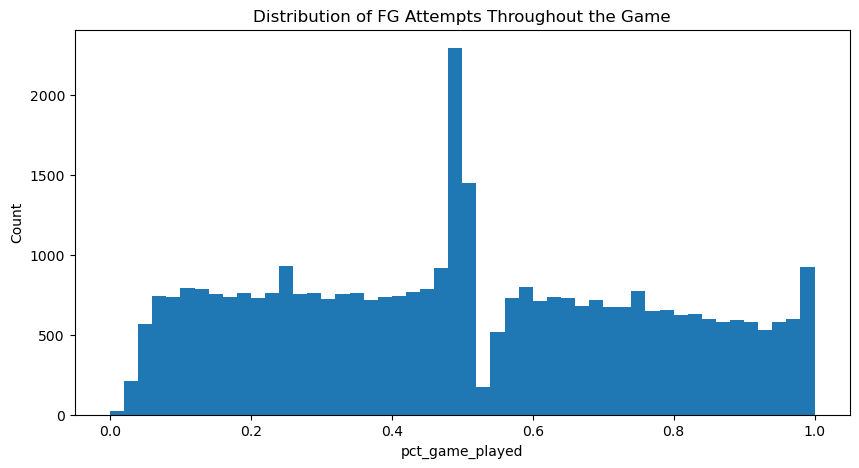

In [19]:
# plot a hist plot of pct_game_played
plt.figure(figsize=(10, 5))
plt.hist(df.pct_game_played, bins=50)
plt.title('Distribution of FG Attempts Throughout the Game')
plt.xlabel('pct_game_played')
plt.ylabel('Count')
plt.show()

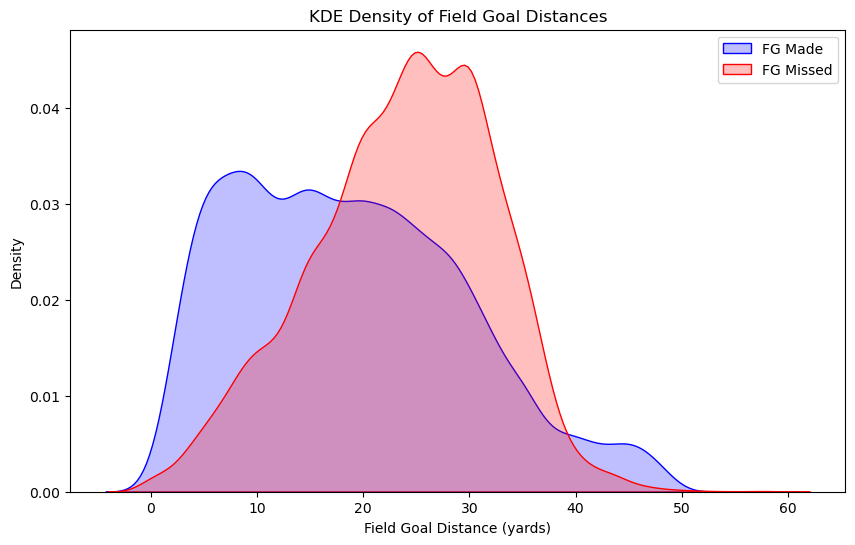

In [20]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df.query('fg_made==1').fg_distance, fill=True, color='blue', label='FG Made')
sns.kdeplot(df.query('fg_made==0').fg_distance, fill=True, color='red', label='FG Missed')
plt.title('KDE Density of Field Goal Distances')
plt.xlabel('Field Goal Distance (yards)')
plt.ylabel('Density')
plt.legend()
plt.show()

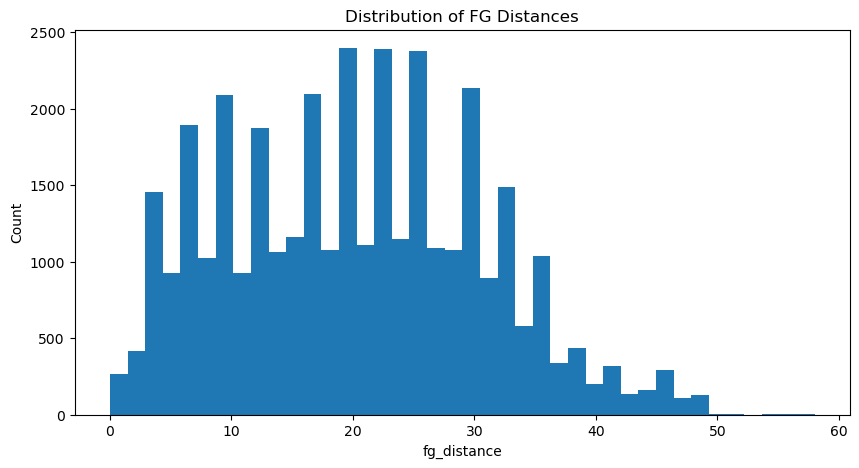

In [21]:
# plot a hist plot of fg_distance
plt.figure(figsize=(10, 5))
plt.hist(df.fg_distance, bins=40)
plt.title('Distribution of FG Distances')
plt.xlabel('fg_distance')
plt.ylabel('Count')
plt.show()

In [22]:
df.head()

,game_id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,defense,drive_id,drive_number,fg_distance,drive_result,is_home_offense,start_offense_score,end_offense_score,start_defense_score,end_defense_score,end_period,end_time_minutes,end_time_seconds,game_indoors,temperature,dew_point,humidity,precipitation,snowfall,wind_speed,pressure,weather_condition,elevation,grass,home_pregame_elo,away_pregame_elo,pct_game_played,score_diff,is_home_team,offense_division,defense_division,off_pts_scored,fg_team_pregame_elo,pressure_rating,fg_made
0,302450154,2010,1,regular,True,False,3630.0,154,Wake Forest,ACC,fbs,2506,Presbyterian,Big South,fcs,Wake Forest,Presbyterian,30245015428,28.0,19.0,FG GOOD,True,44.0,47.0,13.0,13.0,4.0,4.0,13.0,False,86.0,61.0,43.0,0.000,0.0,4.7,1013.3,None,283.548584,False,2360.207140,558.937721,0.929722,31.0,1,fbs,fcs,3.0,2360.207140,0,1
1,302452050,2010,1,regular,True,False,3919.0,2050,Ball State,Mid-American,fbs,2546,Southeast Missouri State,OVC,fcs,Ball State,Southeast Missouri State,30245205016,16.0,12.0,FG GOOD,True,21.0,24.0,7.0,7.0,3.0,0.0,48.0,False,82.0,63.1,53.0,0.000,0.0,11.4,1011.1,None,285.481781,False,1533.534118,811.871140,0.736667,14.0,1,fbs,fcs,3.0,1533.534118,0,1
2,302452050,2010,1,regular,True,False,3919.0,2050,Ball State,Mid-American,fbs,2546,Southeast Missouri State,OVC,fcs,Southeast Missouri State,Ball State,30245205017,17.0,36.0,FG GOOD,False,7.0,10.0,24.0,24.0,4.0,11.0,27.0,False,82.0,63.1,53.0,0.000,0.0,11.4,1011.1,None,285.481781,False,1533.534118,811.871140,0.809167,-17.0,-1,fcs,fbs,3.0,811.871140,0,1
3,302452050,2010,1,regular,True,False,3919.0,2050,Ball State,Mid-American,fbs,2546,Southeast Missouri State,OVC,fcs,Ball State,Southeast Missouri State,30245205018,18.0,1.0,FG GOOD,True,24.0,27.0,10.0,10.0,4.0,5.0,40.0,False,82.0,63.1,53.0,0.000,0.0,11.4,1011.1,None,285.481781,False,1533.534118,811.871140,0.905556,14.0,1,fbs,fcs,3.0,1533.534118,0,1
4,302452117,2010,1,regular,True,False,3786.0,2117,Central Michigan,Mid-American,fbs,2261,Hampton,MEAC,fcs,Central Michigan,Hampton,30245211710,9.0,22.0,FG MISSED,True,23.0,23.0,0.0,0.0,1.0,2.0,53.0,False,71.4,71.4,100.0,0.012,0.0,3.4,NaN,None,240.900772,False,2182.932435,1301.461354,0.201944,23.0,1,fbs,fcs,0.0,2182.932435,0,0


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_24563/3637822262.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


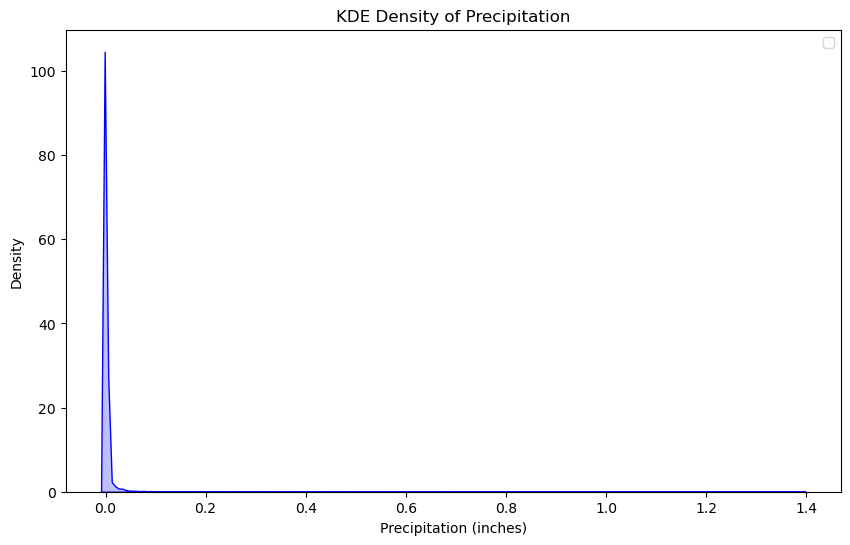

In [23]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df.precipitation, fill=True, color='blue')
plt.title('KDE Density of Precipitation')
plt.xlabel('Precipitation (inches)')
plt.ylabel('Density')
plt.legend()
plt.show()

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_24563/2083828262.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


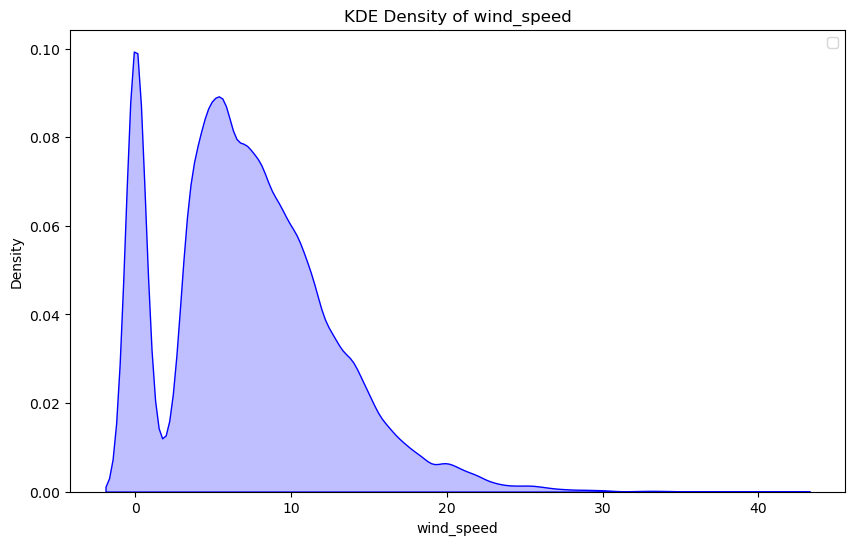

In [24]:
feature = 'wind_speed'
plt.figure(figsize=(10, 6))
sns.kdeplot(df[feature], fill=True, color='blue')
plt.title(f'KDE Density of {feature}')
plt.xlabel(feature)
plt.ylabel('Density')
plt.legend()
plt.show()

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_24563/829338877.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


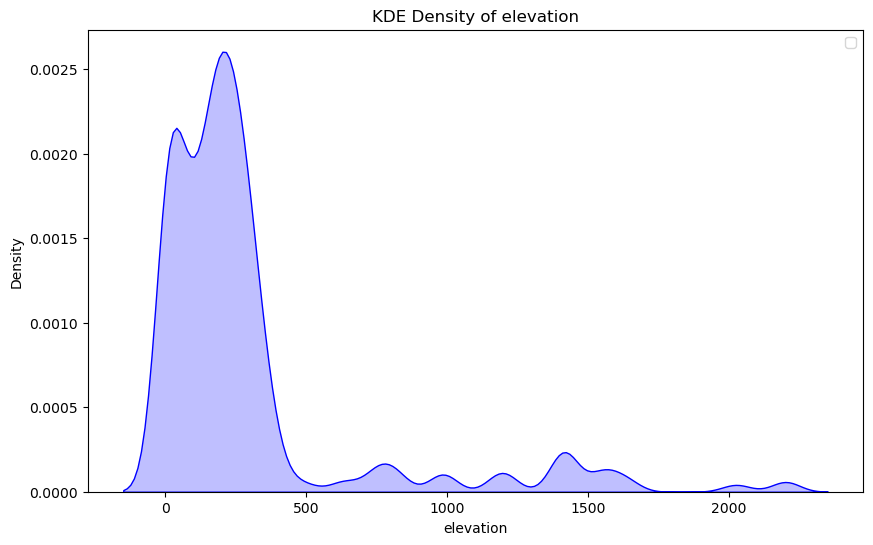

In [25]:
feature = 'elevation'
plt.figure(figsize=(10, 6))
sns.kdeplot(df[feature], fill=True, color='blue')
plt.title(f'KDE Density of {feature}')
plt.xlabel(feature)
plt.ylabel('Density')
plt.legend()
plt.show()

## 5. Make the model

In [85]:
data = df[['game_id', 'fg_distance', 'pressure_rating', 'is_home_team', 
           'grass', 'elevation', 'wind_speed', 'precipitation', 'temperature', 'game_indoors',
           'fg_team_pregame_elo', 'fg_made'
          ]]

# Split into 80-20 train val set by game_id
game_ids = df.game_id.unique()
game_ids_train, game_ids_test = train_test_split(game_ids, test_size=0.2, random_state=42)

data_train = data[data.game_id.isin(game_ids_train)]
data_test = data[data.game_id.isin(game_ids_test)]

In [86]:
data.head()

,game_id,fg_distance,pressure_rating,is_home_team,grass,elevation,wind_speed,precipitation,temperature,game_indoors,fg_team_pregame_elo,fg_made
0,302450154,19.0,0,1,False,283.548584,4.7,0.000,86.0,False,2360.207140,1
1,302452050,12.0,0,1,False,285.481781,11.4,0.000,82.0,False,1533.534118,1
2,302452050,36.0,0,-1,False,285.481781,11.4,0.000,82.0,False,811.871140,1
3,302452050,1.0,0,1,False,285.481781,11.4,0.000,82.0,False,1533.534118,1
4,302452117,22.0,0,1,False,240.900772,3.4,0.012,71.4,False,2182.932435,0


In [87]:
data.isna().sum()

game_id                0
fg_distance            0
pressure_rating        0
is_home_team           0
grass                  0
elevation              0
wind_speed             0
precipitation          0
temperature            0
game_indoors           0
fg_team_pregame_elo    0
fg_made                0
dtype: int64

In [88]:
data_train.game_id.nunique()

9596

In [69]:
df.fg_made.value_counts()

fg_made
1    26279
0     9829
Name: count, dtype: int64

In [89]:
# bin fg distance int bins by 10 yardds, and then pring value counts
bins = np.arange(0, 61, 10)
labels = [f'{i}-{i+10}' for i in bins[:-1]]
df['fg_distance_bins'] = pd.cut(df.fg_distance, bins=bins, labels=labels, right=False)
print(df['fg_distance_bins'].value_counts().sort_index())
df.drop(columns=['fg_distance_bins'], inplace=True)

fg_distance_bins
0-10      7007
10-20    10370
20-30    11525
30-40     5852
40-50     1342
50-60       12
Name: count, dtype: int64


In [149]:
model_dir = os.path.join(DATA_DIR, 'models', 'fg_probability')

model_files = [f for f in os.listdir(model_dir) if f.endswith('.json')]

models = []
for model_file in model_files:
    model_path = os.path.join(model_dir, model_file)
    model = xgb.Booster()  # Create an empty Booster object
    model.load_model(model_path)  # Load the model from the json file
    models.append(model)

print(f"Loaded {len(models)} models from the '{model_dir}' folder.")

Loaded 100 models from the '../data/models/fg_probability' folder.


In [ ]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 2
np.random.seed(SEED)

N_BOOTSTRAP = 100
    
feature_names = data_train.drop(columns=['game_id', 'fg_made']).columns.tolist()
monotonic_constraints_map = {
    "fg_distance": -1,
    "wind_speed": -1,
    "elevation": 1,
    "is_home_team": 1,
    "precipitation": -1,
    "game_indoors": 1,
    "pregame_elo_diff": 1,
    "pressure_rating": -1,
    "fg_team_pregame_elo": 1,
}
monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        "monotone_constraints": monotonic_constraints,
        "eval_metric": "logloss",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.01, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    preds = bst.predict(dvalid)
  
    return log_loss(valid_y, preds)

# Bootstrapping
models = []
for i in tqdm(range(N_BOOTSTRAP), desc='Bootstrapping'):
    # Bootstrap sampling
    game_ids = data_train.game_id.unique()
    game_ids_sample = np.random.choice(game_ids, size=len(game_ids), replace=True)
    train_data = data_train[data_train.game_id.isin(game_ids_sample)]

    # Undersample the data to balance the classes
    # class_1 = train_data[train_data['fg_made'] == 1]
    # class_0 = train_data[train_data['fg_made'] == 0]
    # max_class_size = min(len(class_1), len(class_0))
    # class_1_oversampled = class_1.sample(n=max_class_size, random_state=SEED)
    # class_0_oversampled = class_0.sample(n=max_class_size, random_state=SEED)
    # train_data = pd.concat([class_1_oversampled, class_0_oversampled])
    # train_data = train_data.sample(frac=1, random_state=SEED).reset_index(drop=True)

    
    # Split into 80-20 train-val set by game_id
    game_ids_train, game_ids_valid = train_test_split(train_data.game_id.unique(), test_size=0.2, random_state=SEED)
    train = train_data[train_data.game_id.isin(game_ids_train)]
    valid = train_data[train_data.game_id.isin(game_ids_valid)]
    train_x = train.drop(columns=['game_id', 'fg_made'])
    train_y = train['fg_made']
    valid_x = valid.drop(columns=['game_id', 'fg_made'])
    valid_y = valid['fg_made']
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    study = optuna.create_study(
        study_name="fg_probability_hyperopt", 
        direction="minimize", 
        load_if_exists=True
    )
    study.optimize(lambda trial: objective(trial, dtrain, dvalid), n_trials=50)

    # Train a model with the best params
    best_params = {
        **study.best_trial.params,
        'nthread': -1,
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'monotone_constraints': monotonic_constraints,
        'eval_metric': 'logloss',
        'seed': SEED,
    }
    bst = xgb.train(
        best_params, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    models.append(bst)

Bootstrapping: 100%|██████████| 10/10 [01:07<00:00,  6.72s/it]


Calculating SHAP values: 100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


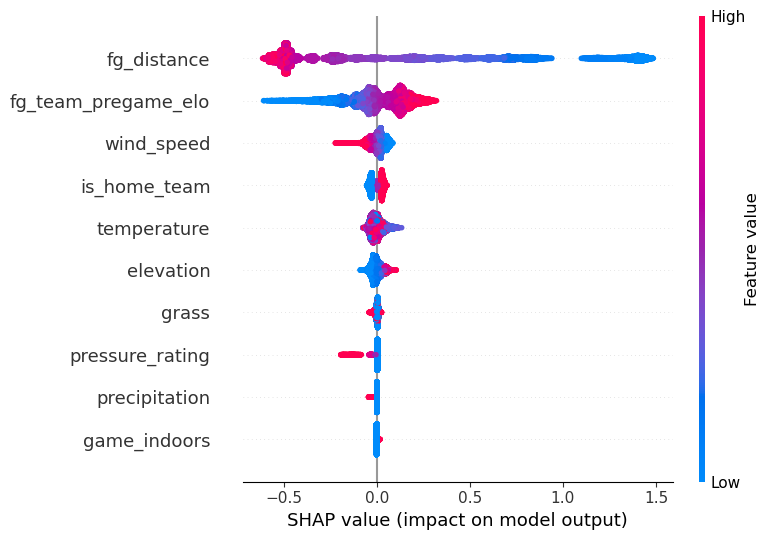

In [99]:
all_shap_values = []

background = data_train.drop(columns=['game_id', 'fg_made'])

for model in tqdm(models, desc='Calculating SHAP values'):
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(background)
    all_shap_values.append(shap_vals)

shap_values_array = np.stack(all_shap_values)  # shape: (n_models, n_samples, n_features)
mean_shap_values = np.mean(shap_values_array, axis=0)  # shape: (n_samples, n_features)

shap.summary_plot(mean_shap_values, background)

Calculating Feature Importance: 100%|██████████| 10/10 [00:00<00:00, 3059.75it/s]


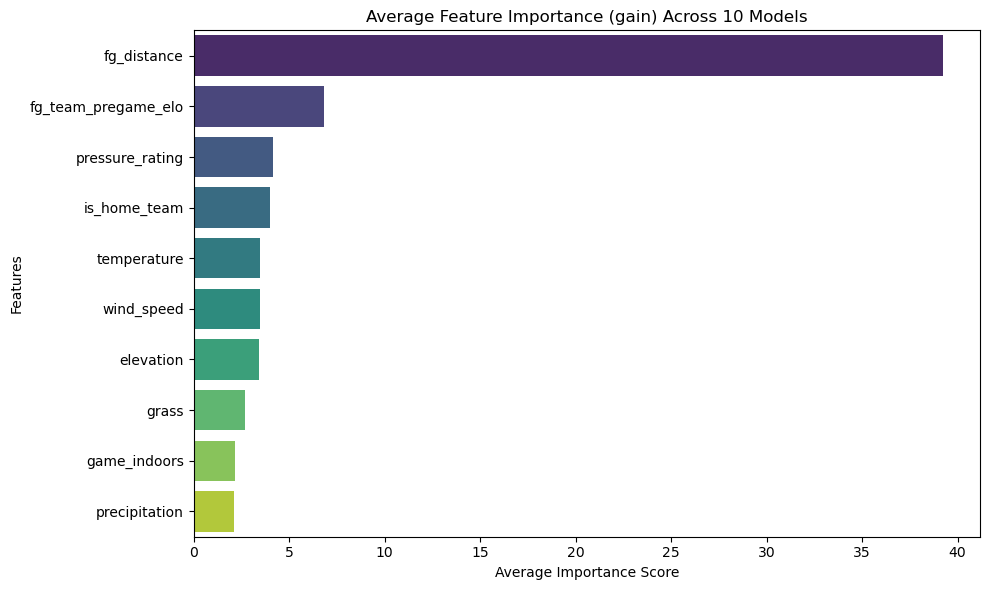

In [91]:
def plot_aggregated_feature_importance(models, importance_type="gain"):
    total_importance = {}

    # Aggregate importances across all models
    for model in tqdm(models, desc='Calculating Feature Importance'):
        importance = model.get_score(importance_type=importance_type)
        for feat, score in importance.items():
            total_importance[feat] = total_importance.get(feat, 0) + score

    # Average the importance by number of models
    for feat in total_importance:
        total_importance[feat] /= len(models)

    importance_df = pd.DataFrame({
        "Feature": list(total_importance.keys()),
        "Importance": list(total_importance.values())
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x="Importance", 
        y="Feature", 
        data=importance_df, 
        palette="viridis", 
        hue="Feature", 
        dodge=False
    )
    plt.title(f"Average Feature Importance ({importance_type}) Across {len(models)} Models")
    plt.xlabel("Average Importance Score")
    plt.ylabel("Features")
    plt.legend([], [], frameon=False)
    plt.tight_layout()
    plt.show()

plot_aggregated_feature_importance(models, importance_type="gain") # gain, weight, cover

Average Test Log Loss over 10 models: 0.54266


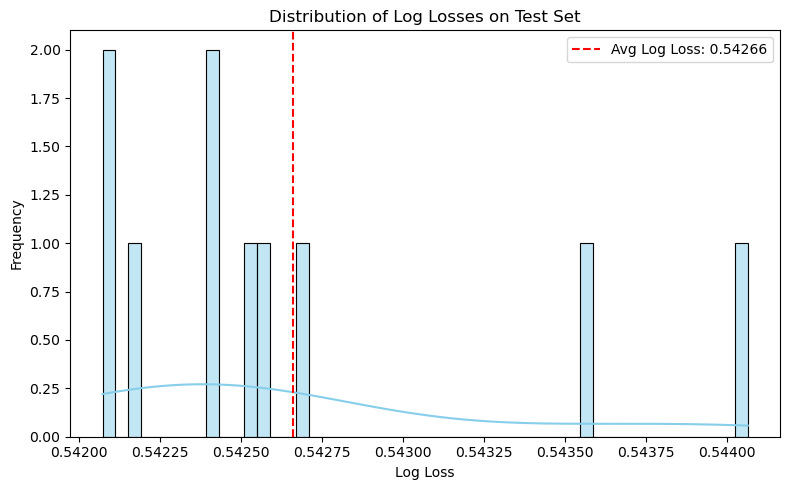

In [92]:
test_x = data_test.drop(columns=['game_id', 'fg_made'])
test_y = data_test['fg_made'].values.ravel()
dtest = xgb.DMatrix(test_x)

loglosses = []

for model in models:
    preds = model.predict(dtest)
    loss = log_loss(test_y, preds)
    loglosses.append(loss)

avg_logloss = np.mean(loglosses)
print(f"Average Test Log Loss over {len(models)} models: {avg_logloss:.5f}")

plt.figure(figsize=(8, 5))
sns.histplot(loglosses, bins=50, kde=True, color="skyblue")
plt.axvline(avg_logloss, color="red", linestyle="--", label=f"Avg Log Loss: {avg_logloss:.5f}")
plt.title("Distribution of Log Losses on Test Set")
plt.xlabel("Log Loss")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

In [93]:
data_all = data.drop(columns=['game_id', 'fg_made'])
dall = xgb.DMatrix(data_all)

preds_all_models = []

for model in models:
    preds = model.predict(dall)
    preds_all_models.append(preds)

preds_all_models = np.array(preds_all_models)

# Calculate the 5%, 50%, 95% percentiles and the mean for each sample
df['fg_proba_5'] = np.percentile(preds_all_models, 5, axis=0)
df['fg_proba_50'] = np.percentile(preds_all_models, 50, axis=0)
df['fg_proba_95'] = np.percentile(preds_all_models, 95, axis=0)
df['fg_proba_mean'] = np.mean(preds_all_models, axis=0)

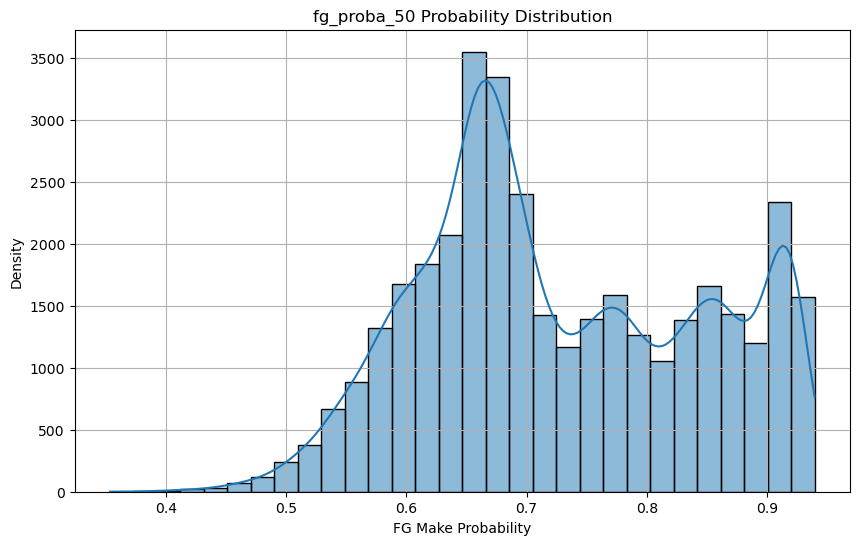

In [94]:
# plot win probability
def plot_wp(df, col='fg_proba_50'):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'{col} Probability Distribution')
    plt.xlabel('FG Make Probability')
    plt.ylabel('Density')
    plt.grid()
    plt.show()
plot_wp(df, col='fg_proba_50')

In [95]:
df.fg_proba_50.describe()

count    36108.000000
mean         0.727167
std          0.115654
min          0.353400
25%          0.643953
50%          0.700048
75%          0.830565
max          0.939576
Name: fg_proba_50, dtype: float64

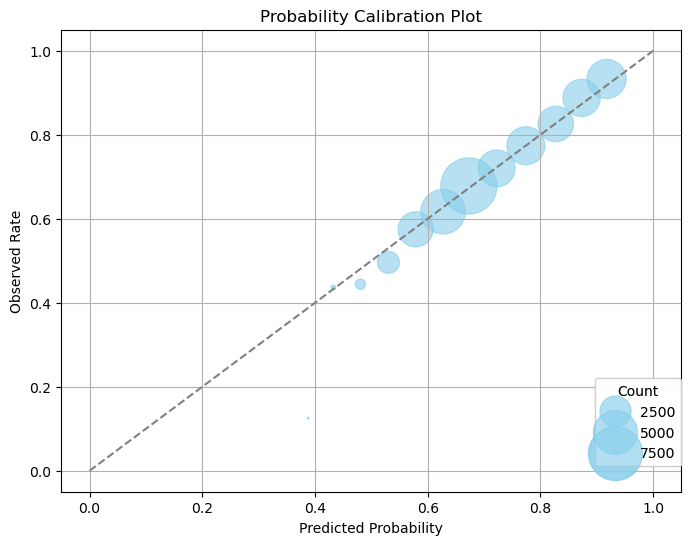

In [96]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        calibration['predicted_proba'], 
        calibration['actual_proba'], 
        s=calibration['count'] * scale,
        alpha=0.6, 
        label='Calibration Curve',
        color='skyblue',
    )
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()

    # Add legend for dot size reference
    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, num=4, func=lambda x: x / scale,
                                              color='skyblue')
    labels = [int(re.search(r'\{(\d+)\}', value).group(1)) for value in labels]
    legend = plt.legend(handles, labels, title="Count", loc="center left", bbox_to_anchor=(.85, 0.15))
    plt.gca().add_artist(legend)

    plt.show()

plot_calibration(df, proba_col='fg_proba_50', actual_col='fg_made', bins=20)

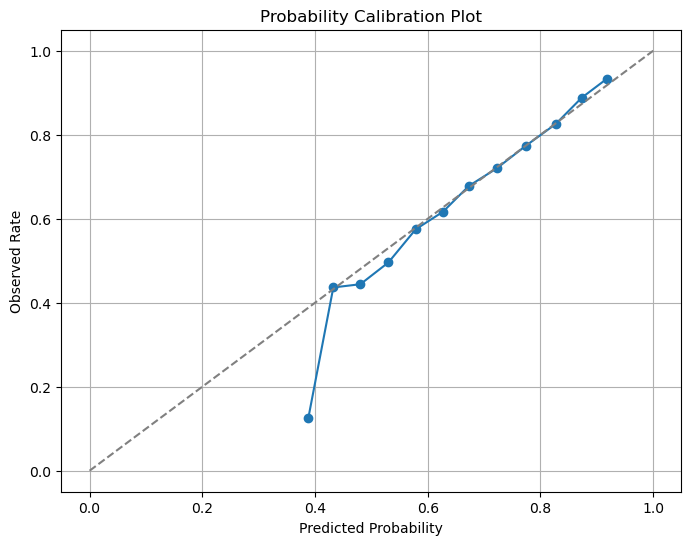

In [97]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    plt.plot(calibration['predicted_proba'], calibration['actual_proba'], label='Calibration Curve', marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()
    plt.show()

plot_calibration(df, proba_col='fg_proba_50', actual_col='fg_made', bins=20)

Optimal shift: 0.0006


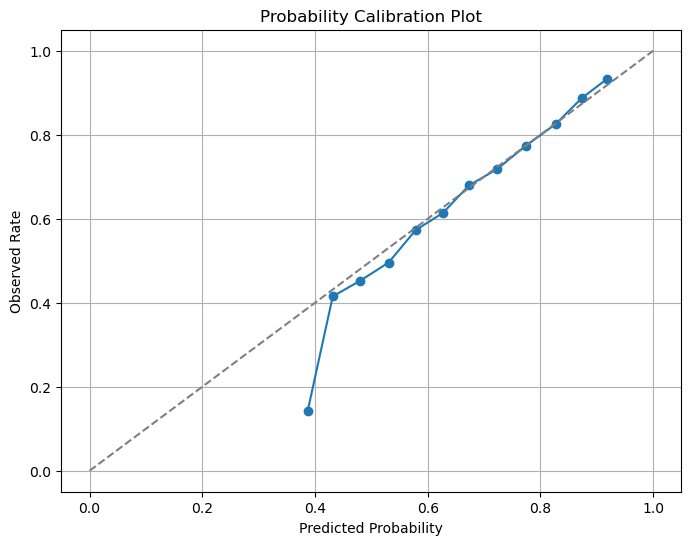

In [98]:
# shift the probabilites to fit the calibraion curve (use optimizaiton for best shift)
def optimize_shift(df, proba_col, actual_col):
    def objective(shift):
        shifted_proba = df[proba_col] + shift
        shifted_proba = np.clip(shifted_proba, 0, 1)
        return np.mean((df[actual_col] - shifted_proba) ** 2)

    result = minimize_scalar(objective, bounds=(-0.5, 0.5), method='bounded')
    return result.x
from scipy.optimize import minimize_scalar
shift = optimize_shift(df, proba_col='fg_proba_50', actual_col='fg_made')
print(f"Optimal shift: {shift:.4f}")
df['fg_proba_50_shifted'] = df['fg_proba_50'] + shift
df['fg_proba_50_shifted'] = np.clip(df['fg_proba_50_shifted'], 0, 1)
plot_calibration(df, proba_col='fg_proba_50_shifted', actual_col='fg_made', bins=20)

In [83]:
df[data.columns.tolist() + ['fg_proba_5','fg_proba_50_shifted','fg_proba_95']].sort_values(by='fg_proba_50_shifted', ascending=True).head(100)

,game_id,fg_distance,pressure_rating,is_home_team,grass,elevation,wind_speed,precipitation,temperature,game_indoors,fg_team_pregame_elo,score_diff,pct_game_played,fg_made,fg_proba_5,fg_proba_50_shifted,fg_proba_95
26382,401301010,31.0,0,-1,False,3.198707,4.3,0.000,73.4,False,623.820647,-10.0,0.500000,0,0.275509,0.330532,0.429240
20024,401015002,33.0,0,-1,False,1.718582,13.0,0.000,84.6,False,395.338885,-35.0,0.498333,0,0.215977,0.336271,0.406733
16650,400935232,36.0,4,-1,False,223.247162,9.2,0.000,66.0,False,1384.027224,-3.0,1.000000,0,0.209830,0.336382,0.424319
7374,332640264,30.0,0,-1,False,11.656228,7.0,0.000,64.9,False,743.385263,-42.0,0.555000,0,0.295772,0.344148,0.436915
1265,302960309,30.0,0,-1,False,3.556508,9.2,0.000,81.1,False,804.417633,17.0,0.500000,1,0.237814,0.347997,0.429228
35450,401629046,25.0,4,1,False,46.586647,19.9,0.000,60.8,False,899.600960,0.0,1.000000,0,0.295188,0.349379,0.472863
28802,401414780,37.0,0,1,False,46.586647,11.8,0.000,70.2,False,801.213125,14.0,0.500000,0,0.253309,0.349469,0.470345
26500,401282210,27.0,0,-1,False,7.148302,4.3,0.000,82.6,False,230.783539,-17.0,0.500000,1,0.290243,0.351131,0.423228
701,302680058,28.0,0,-1,True,11.079729,8.1,0.000,87.1,False,847.749502,-7.0,0.500000,0,0.268188,0.354184,0.450051
18136,400938893,27.0,4,1,False,46.586647,13.9,0.000,68.0,False,1203.092839,-3.0,1.000000,1,0.323627,0.360919,0.459395


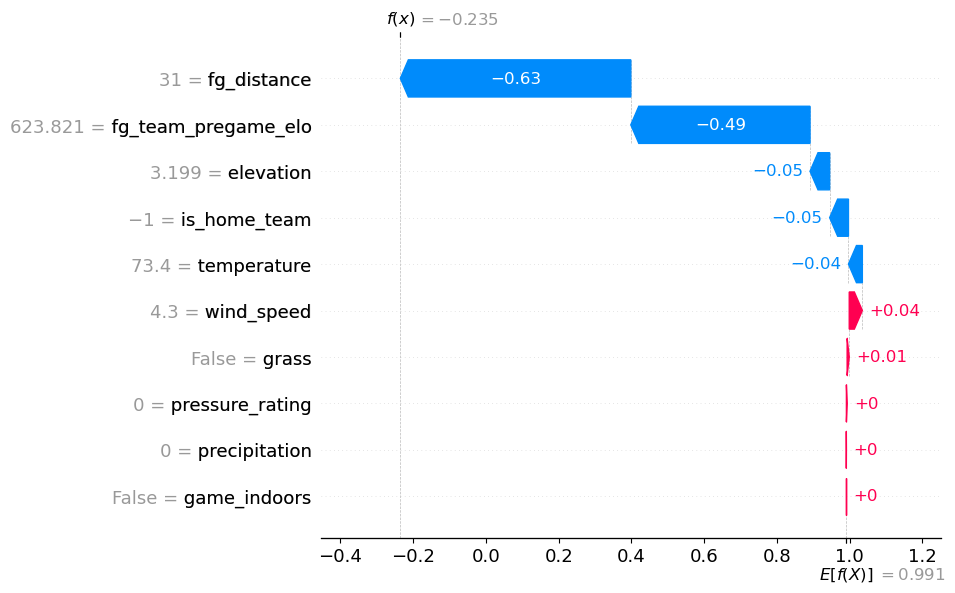

In [100]:
idx = 26382

model = models[0]

game_data = data[data.index == idx].drop(columns=['game_id', 'fg_made']).head(1)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(game_data)
shap_values_explained = shap.Explanation(values=shap_values, 
                                         base_values=explainer.expected_value, 
                                         data=game_data, 
                                         feature_names=game_data.columns)

shap.plots.waterfall(shap_values_explained[0])
plt.show()

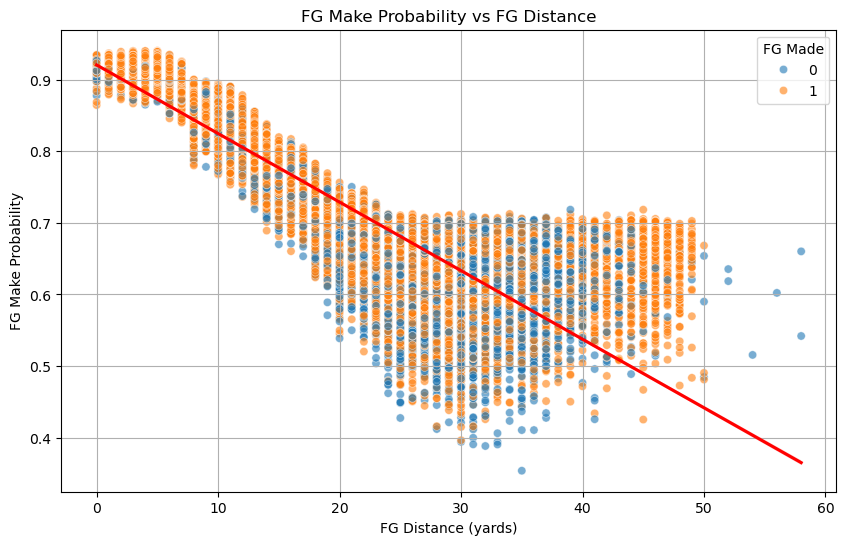

In [101]:
# plot fg_proba_50 vs fg_distance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='fg_distance', y='fg_proba_50_shifted', hue='fg_made', alpha=0.6)
# plot best fit line
sns.regplot(data=df, x='fg_distance', y='fg_proba_50_shifted', scatter=False, color='red', line_kws={'label': 'Best Fit Line'})
plt.title('FG Make Probability vs FG Distance')
plt.xlabel('FG Distance (yards)')
plt.ylabel('FG Make Probability')
plt.grid()
plt.legend(title='FG Made', loc='upper right')
plt.show()

## 6. Save the models

In [67]:
model_dir = join(DATA_DIR, 'models', 'fg_probability')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

for i, model in enumerate(models):
    model_path = os.path.join(model_dir, f"model_{i}.json")
    model.save_model(model_path)

print(f"Saved {len(models)} models to the '{model_dir}' folder.")

Saved 100 models to the '../data/models/fg_probability' folder.
